#### **MODELING**

This notebook implements machine learning models based on the comprehensive EDA findings and preprocessing recommendations. We follow an evidence-based approach to ensure the modeling strategy aligns with the data characteristics and patterns identified earlier.

**Modeling Strategy**

1. **Model Selection** – Logistic Regression (baseline), Random Forest, and XGBoost (EDA recommendations)
2. **Model Evaluation** – Confusion matrix, classification report, ROC-AUC, balanced accuracy, and macro F1
3. **Explainability** – SHAP values and model coefficients for feature interpretation

**EDA Evidence for Modeling**

1. **Non-linear interactions** – Use tree-based models (Random Forest, XGBoost) to capture complex feature relationships
2. **Production focus**– Select interpretable and stable models suitable for deployment and policy insights

#### **1. Import Libraries and Load Preprocessed Data**

In [16]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                            balanced_accuracy_score, f1_score, precision_score, recall_score)
import joblib

# Advanced ML libraries
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost not available. Install with: pip install xgboost")

try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("LightGBM not available. Install with: pip install lightgbm")

# Explainability
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("SHAP not available. Install with: pip install shap")

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"XGBoost available: {XGBOOST_AVAILABLE}")
print(f"LightGBM available: {LIGHTGBM_AVAILABLE}")
print(f"SHAP available: {SHAP_AVAILABLE}")

Libraries imported successfully!
XGBoost available: True
LightGBM available: True
SHAP available: True


In [17]:
# Load preprocessed datasets
print("LOADING PREPROCESSED DATA")

try:
    # Load preprocessed datasets
    X_train = pd.read_csv('Scaled_X_train.csv')
    X_test = pd.read_csv('Scaled_X_test.csv')

    y_train = pd.read_csv('y_train.csv').squeeze()
    y_test = pd.read_csv('y_test.csv').squeeze()

    # The .squueze() method removes dimensions of size 1 , converting a DataFrame to a Series
    # The .squeeze() method is a clean, robust way to ensure your target variables are in the correct 1D format that sklearn expects,
    # preventing potential errors during model training and evaluation.

    # Load preprecessing objects
    scaler = joblib.load('scaler.pkl')
    selected_features = joblib.load('selected_features.pkl')

    print("...Preprocessed data loaded successfully!!!...")
    print(f"Training set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")

    # Display class distribution
    print("\nClass Distribution:")
    print("Training set:")
    print(y_train.value_counts().sort_index())
    print("\n Test set:")
    print(y_test.value_counts().sort_index())

    # Display selected features
    print(f"\nSelected features ({len(selected_features)}):")
    for i, feature in enumerate(selected_features, 1):
        print(f"{i:2d}. {feature}")
        
except FileNotFoundError as e:
    print(f"Error loading preprocessed data: {e}")
    print("Please run the preprocessing notebook first to generate the required files.")
    print("Required files: Scaled_X_train.csv, Scaled_X_test.csv")
    print("                y_train.csv, y_test.csv")
    print("                scaler.pkl, selected_features.pkl")

LOADING PREPROCESSED DATA
...Preprocessed data loaded successfully!!!...
Training set: (675, 15)
Test set: (169, 15)

Class Distribution:
Training set:
Loan_Status
0    328
1    347
Name: count, dtype: int64

 Test set:
Loan_Status
0    94
1    75
Name: count, dtype: int64

Selected features (15):
 1. Gender
 2. Married
 3. Dependents
 4. Education
 5. Self_Employed
 6. Credit_History
 7. Property_Area
 8. Loan_Amount_Term_year
 9. Has_Coapplicant
10. income_category
11. ApplicantIncome_log
12. CoapplicantIncome_log
13. LoanAmount_log
14. Total_income_log
15. EMI_log


#### **2. Baseline Model - Logistic Regression**


In [ ]:
# Baseline Logistic Regression Model
print("BASELINE LOGISTIC REGRESSION MODEL")
print("EDA recommendation: Fast, interpretable baseline with co-efficients for feature effect direction")


# Create and train baseline model 
baseline_model = LogisticRegression(random_state=234, max_iter=1000)

# Train the model
baseline_model.fit(X_train, y_train)

# Make Predictions
y_train_pred = baseline_model.predict(X_train)
y_test_pred = baseline_model.predict(X_test)

# Calculate metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_f1 = f1_score(y_train, y_train_pred, average='macro')
test_f1 = f1_score(y_test, y_test_pred, average='macro')

print(f"\nBaseline Model Performance:")
print(f"Training - Accuracy: {train_accuracy:.3f}, Macro F1: {train_f1:.3f}")
print(f"Test - Accuracy: {test_accuracy:.3f}, Macro F1: {test_f1:.3f}")

# Display feature coefficients (interpretability)
print(f"\nFeature Coefficients (Top 10):")
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': baseline_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

for i, (_, row) in enumerate(feature_importance.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']}: {row['coefficient']:.3f}")

# Store baseline results
baseline_results = {
    'model': 'Logistic Regression',
    'train_accuracy': train_accuracy,
    'test_accuracy': test_accuracy,
    'train_f1': train_f1,
    'test_f1': test_f1
}

print(".... Baseline model completed!")




BASELINE LOGISTIC REGRESSION MODEL
EDA recommendation: Fast, interpretable baseline with co-efficients for feature effect direction

Baseline Model Performance:
Training - Accuracy: 0.754, Binary F1: 0.747
Test - Accuracy: 0.598, Binary F1: 0.575

Feature Coefficients (Top 10):
 1. Married: 1.040
 2. Self_Employed: 0.937
 3. CoapplicantIncome_log: 0.835
 4. income_category: 0.813
 5. Has_Coapplicant: -0.731
 6. EMI_log: -0.543
 7. Property_Area: 0.536
 8. Credit_History: 0.351
 9. LoanAmount_log: 0.172
10. Total_income_log: -0.161
.... Baseline model completed!


#### **3. Random Forest Classifier(EDA)**



RANDOM FOREST CLASSIFIER
EDA recommendation: Robust, captures interactions, insensitive to sclaing and moderate outlier outliers

Random Forest Performance
Training - Accuracy: 1.000, Macro:1.000
Test - Accuracy: 0.7751479289940828, Macro: 0.7751479289940828

Feature Importance (Top 10):
 1. Credit_History: 0.263
 2. Total_income_log: 0.126
 3. ApplicantIncome_log: 0.118
 4. EMI_log: 0.112
 5. LoanAmount_log: 0.110
 6. CoapplicantIncome_log: 0.068
 7. Property_Area: 0.043
 8. Dependents: 0.041
 9. Loan_Amount_Term_year: 0.025
10. income_category: 0.022


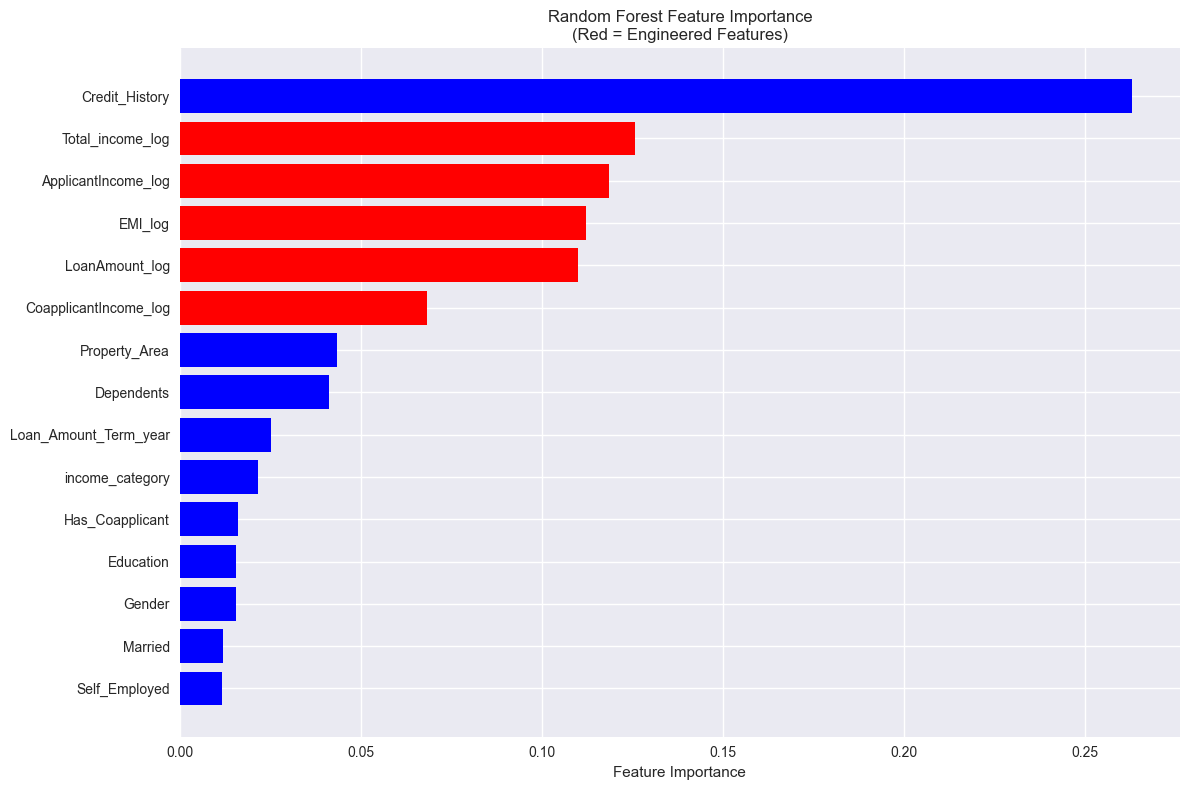

....Random Forest model completed...!


In [22]:
# Random Forest classifier
print("RANDOM FOREST CLASSIFIER")
print("EDA recommendation: Robust, captures interactions, insensitive to sclaing and moderate outlier outliers")

# Create Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=234, n_jobs=-1)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# Calculate metrics
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf) 

train_f1_rf = f1_score(y_train, y_train_pred_rf, average='macro')
test_f1_rf = f1_score(y_test, y_test_pred_rf, average='macro')

print(f"\nRandom Forest Performance")
print(f"Training - Accuracy: {train_accuracy_rf:.3f}, Macro:{train_accuracy_rf:.3f}")
print(f"Test - Accuracy: {test_accuracy_rf}, Macro: {test_accuracy_rf}")

# Feature importance analysis
print(f"\nFeature Importance (Top 10):")
feature_importance_rf = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

for i, (_, row) in enumerate(feature_importance_rf.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']}: {row['importance']:.3f}")

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features_rf = feature_importance_rf.head(15)
colors = ['red' if any(keyword in f.lower() for keyword in ['ratio', 'interaction', 'balance', 'total', 'log']) else 'blue' for f in top_features_rf['feature']]

plt.barh(range(len(top_features_rf)), top_features_rf['importance'], color=colors)
plt.yticks(range(len(top_features_rf)), top_features_rf['feature'])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance\n(Red = Engineered Features)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Store Random Forest results
rf_results = {
    'model': 'Random Forest',
    'train_accuracy': train_accuracy_rf,
    'test_accuracy': test_accuracy_rf,
    'train_f1': train_f1_rf,

    'test_f1': test_f1_rf
}

print("....Random Forest model completed...!")